# Hand Gesture Recognition

By Jonathan Christyadi - 502705

## Introduction
Hand gesture recognition is a critical component of human-computer interaction, enabling intuitive control of devices using natural hand movements. This project focuses on the development and evaluation of a Convolutional Neural Network (CNN) model for recognizing various hand gestures, utilizing a comprehensive dataset provided by the Universidad de Alicante. The dataset comprises real images, synthetic images, and scene descriptions, designed to train and evaluate hand gesture detection methods.

# Dataset Overview
The original images and videos were recorded at a resolution of 1,920 x 1,080 pixels. However, for performance and accuracy reasons, the images were scaled down to a spatial resolution of 224 x 224 pixels.

Dataset sources: https://www.dlsi.ua.es/~jgallego/datasets/gestures/


Gesture Categories and Dataset Summary
The dataset encompasses the following gesture categories:

- Point: Images of pointing gestures.
- Drag: Images including drag gestures.
- Loupe: Samples including loupe gestures.
- Pinch: Sequences of dynamic pinch gestures.
- None: Samples where no hand appears.

The dataset is highly suitable for training robust hand gesture recognition models due to its quality and diversity, as evidenced by several key factors:

1. Variety in Real Images: The real images dataset includes frames extracted from videos recorded in varied environments, including indoor and outdoor scenes, with different lighting conditions and backgrounds.
2. Balanced Gesture Representation: The dataset ensures balanced representation of each gesture category, with a comparable number of samples for point, drag, loupe, pinch, and none. 
3. Comprehensive Annotations: The dataset provides detailed annotations, including bounding boxes for hand positions, fingertips, and objects pointed to.
4. High-Quality Image Resolution: Although the original images were recorded at a high resolution of 1,920 x 1,080 pixels, they were downscaled to 224 x 224 pixels for practical reasons. 

Nevertheless, there are some limitation about the data, for example: the skin tone color of the hand in the pictures. Most of the skin color in the images are either white or brown but does not include black. 

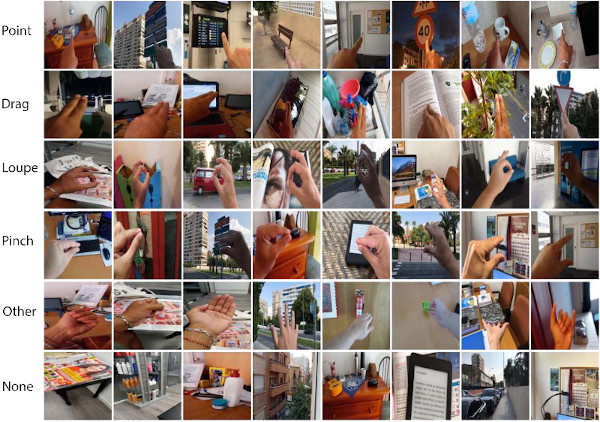

# Project Objectives
This project aims to build a robust CNN model capable of accurately recognizing hand gestures from images, leveraging the rich and varied dataset provided. The model will be trained, validated, and tested on real data to ensure generalization across different environments and conditions. Additionally, the project includes a data preprocessing pipeline, data augmentation strategies, and a detailed evaluation process to measure the model's performance.

## Imports Libraries

In [40]:
import os
import cv2
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import random
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split


# Data Preprocessing

First I want to specify the set of labels (gestures) that the model will be trained to recognize and sets up the directory for accessing the images and their annotations. 

In [41]:
# Define the classes
labels_to_include = ['Drag', 'Loupe', 'Point', 'Scale', 'None']

# Define the paths
dataset_path = r'C:\Kuliah\Semester 4\hand-detector\dataset'
annotation_path = os.path.join(dataset_path, 'annotations')
image_path = os.path.join(dataset_path, 'images')

Since the images and annotations are in a different folder, I need to combine both file. Also, I need to extract the relevant information from the annotation file such as the box x and y coordinates. 

In [42]:
def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    bndboxes = []
    
    # Derive label from the annotation file path
    annotation_dir = os.path.dirname(annotation_file)
    label = os.path.basename(annotation_dir)
    
    if label not in labels_to_include:
        return None, None, None

    for obj in root.findall('object'):
        name = obj.find('name').text
        
        # Skip objects not in labels_to_include
        if name not in labels_to_include:
            continue

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bndboxes.append((xmin, ymin, xmax, ymax))

    filename = root.find('filename').text
    return filename, bndboxes, label

## Data Preparation

Defines a dataset class that can be used with PyTorch's data loading utilities. Then images are resized to a standard size of 224x224 pixels, and optional transformations can be applied. The class handles cases where there are no annotations (e.g., 'None' class) by returning an empty list for bounding boxes.


In [43]:
class CustomDataset(Dataset):
    def __init__(self, images, annotations, transform=None):
        self.images = images
        self.annotations = annotations
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        annotation = self.annotations[idx]
        
        if annotation[1] is None:
            bndboxes = []
        else:
            bndboxes = annotation[1]

        image = cv2.resize(image, (224, 224))

        if self.transform:
            image = self.transform(image)
        
        return image, bndboxes, annotation[2]  # image, annotations, label

## Data Loading

Reads images and their corresponding annotations from the dataset. This function iterates over the labels, reads images from the respective directories, and parses their annotations. For the 'None' class, it directly reads images without looking for annotations. For other classes, it reads both images and their XML annotations. 

In [44]:
def load_images_and_annotations():
    images = []
    annotations = []

    for label in labels_to_include:
        image_folder = os.path.join(image_path, label)

        if label == 'None':
            # For images in the None folder (no annotations)
            if os.path.exists(image_folder):
                for image_file in os.listdir(image_folder):
                    image_filepath = os.path.join(image_folder, image_file)
                    image = cv2.imread(image_filepath)
                    if image is not None:
                        images.append(image)
                        annotations.append((image_file, torch.empty((0, 4)), label))
                    else:
                        print(f"Image not found or cannot be read: {image_filepath}")
            else:
                print(f"Image folder does not exist: {image_folder}")
        else:
            annotation_folder = os.path.join(dataset_path, 'annotations', label)
            if os.path.exists(annotation_folder):
                for annotation_file in os.listdir(annotation_folder):
                    annotation_filepath = os.path.join(annotation_folder, annotation_file)
                    filename, bndboxes, parsed_label = parse_annotation(annotation_filepath)
                    if filename:
                        image_filepath = os.path.join(image_folder, filename)
                        image = cv2.imread(image_filepath)
                        if image is not None:
                            images.append(image)
                            annotations.append((filename, bndboxes, parsed_label))  # Attach bounding boxes properly
                        else:
                            print(f"Image not found or cannot be read: {image_filepath}")
                    else:
                        print(f"Failed to parse annotation: {annotation_filepath}")
            else:
                print(f"Annotation path does not exist: {annotation_folder}")

    return images, annotations

## Data Exploratory

First I need to organize annotations into separate groups based on their labels. Then, I want to iterate through the annotations, and for each annotation, it adds it to the appropriate list in the dictionary based on its label.

In [45]:
# Group annotations by class
def group_annotations_by_class(annotations):
    grouped_annotations = {label: [] for label in labels_to_include}
    for annotation in annotations:
        filename, bndboxes, label = annotation
        if label in grouped_annotations:
            grouped_annotations[label].append(annotation)
    return grouped_annotations

Then I want to visualizes random sample images from each class with their bounding boxes. It then creates a plot with subplots for each label. For each label, it randomly selects an annotation, retrieves the corresponding image, draws bounding boxes on the image, and displays it.

In [46]:
# Function to plot random samples from each class
def plot_random_samples(images, annotations):
    grouped_annotations = group_annotations_by_class(annotations)
    fig, axes = plt.subplots(1, len(labels_to_include), figsize=(20, 5))
    for i, label in enumerate(labels_to_include):
        ax = axes[i]
        if label in grouped_annotations and len(grouped_annotations[label]) > 0:
            random_annotation = random.choice(grouped_annotations[label])
            filename, bndboxes, _ = random_annotation
            image_idx = [i for i, ann in enumerate(annotations) if ann == random_annotation][0]
            image = images[image_idx]

            # Draw bounding boxes if they exist
            if bndboxes is not None:
                for (xmin, ymin, xmax, ymax) in bndboxes:
                    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)  # Draw in BGR format
            
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            ax.imshow(image_rgb)
            ax.set_title(label)
            ax.axis('off')
        else:
            ax.set_title(f'No {label}')
            ax.axis('off')
    plt.show()

Here is a transformer code and used to convert Image into a Pytorch tensor (input toa  neural network). 
Normalization helps in faster convergence during training by ensuring the pixel values are within a specific range, in this case from 0 - 255 to 0.0 to 1.0.
- ToTensor() ensures the image is represented numerically as a tensor.
- Normalize() ensures the input data has a consistent numeric range and distribution, which helps in training the neural network more effectively.

In [47]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Now I load the images and their annotations from the directory. Then the resulting images and annotations are stored in a list called images and annotations.

In [48]:
images, annotations = load_images_and_annotations()

## Visualization

Now I want to get a random images and its label to proof that each images and its annotations are correctly loaded.

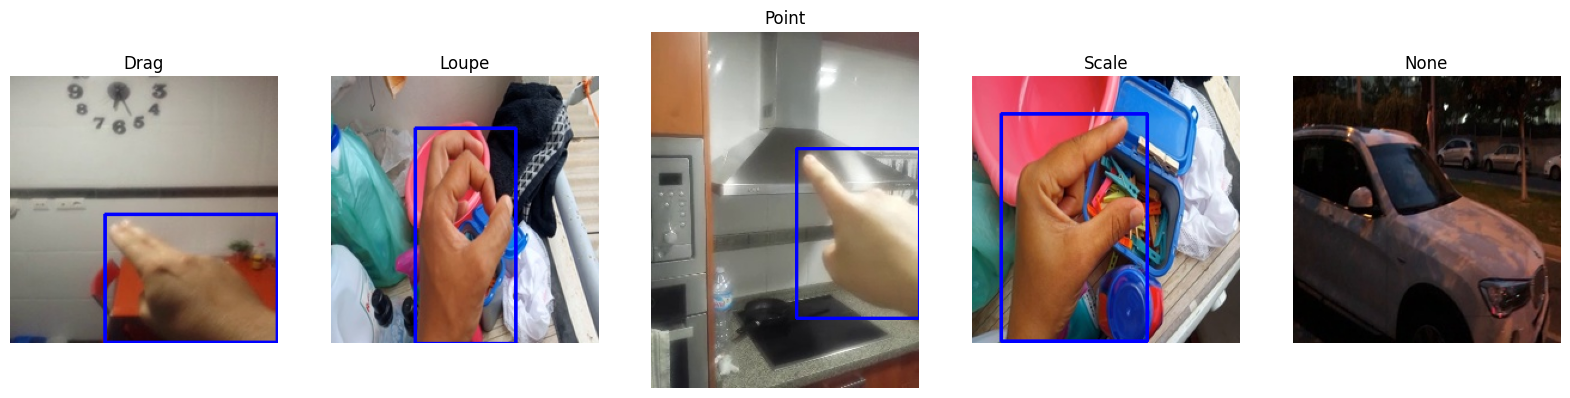

In [49]:
plot_random_samples(images, annotations)

## Visualizes the distribution of images across different classes in the dataset.

I want to check the images distribution from each classes. The total distribution should be somewhat or close to equal. In this case, the data distribution are equally spreaded around 2000 images and annotation from each classes.

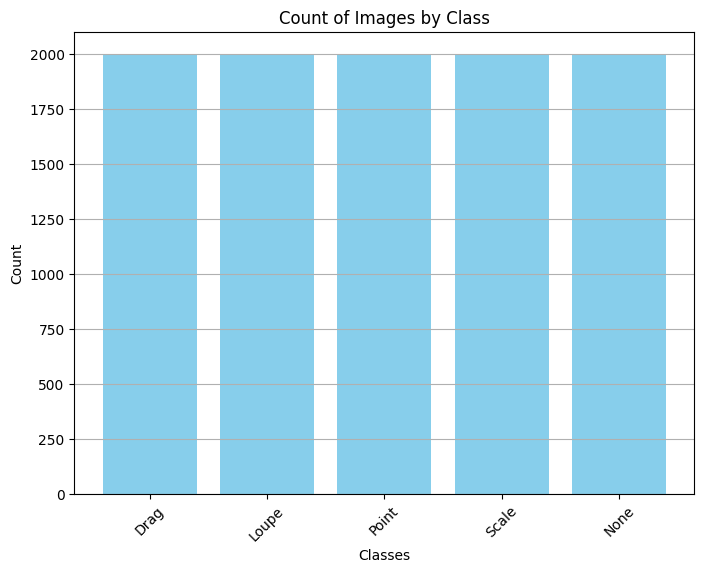

In [50]:
# Function to plot the count of each class
def plot_class_counts(annotations):
    labels = [annotation[2] for annotation in annotations if annotation[2] in labels_to_include]
    label_counts = {label: labels.count(label) for label in labels_to_include}

    plt.figure(figsize=(8, 6))
    plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Count of Images by Class')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    plt.show()

plot_class_counts(annotations)

Now I want to load the images and annotations into one variable called `dataset`.

In [51]:
dataset = CustomDataset(images, annotations, transform=transform)


In [52]:
def custom_collate_fn(batch):
    images = []
    bndboxes = []
    labels = []

    for item in batch:
        images.append(item[0])
        bndboxes.append(item[1])
        labels.append(item[2])

    # Stack images into a single tensor
    images = torch.stack(images, dim=0)

    return images, bndboxes, labels

# Data Splitting

The dataset (images and annotations) is split into training and validatio sets using train_test_split from sklearn. The distribution are 80%-20% respectively. 

In [53]:
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size=0.3, random_state=42)

Now to train pytorch's neural network, I need to make pytorch's dataset and dataloder, to create pytorch's dataset objects (train_dataset, val_dataset). The difference between dataset and dataloader is, dataset holds all the data you want to work with, while the dataloader helps manage and deliver that data in a structured manner to the machine learning model, making the learning process smoother and more efficient.

In [54]:
batch_size = 32

In [55]:
train_dataset = CustomDataset(train_images, train_annotations, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)

To create PyTorch DataLoader objects (train_dataloader, val_dataloader, test_dataloader) for efficient batch processing during model training and evaluation. Ensures randomness in the order of batches during training (shuffle=True for train_dataloader).

In [56]:
# Define validation dataset and dataloader
val_dataset = CustomDataset(val_images, val_annotations, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=custom_collate_fn)


# Modelling

In this project, I want to try to use a simple neural network (CNN). 

# Importing Libraries for modelling purposes

I will use neural network libraries by pytorch. I use this library because it support cuda training which greatly improve training time compared to normal training using CPU. I tried other library such as tensorflow, however in my machined it did not support cuda.

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F


In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


Here I initialized the model design of CNN using deep learning techniques. It consists of several layers that process image data to learn features and make predictions. The model architecture consists of 3 convolutional layers (these layers apply filters to the input image to extract features). Batch normalization, pooling layers, and connected layers. 

In [59]:
# Define a more complex CNN model with batch normalization and dropout
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # 3 input channels (RGB), 16 output channels, 3x3 kernel size, 
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Define the first fully connected layer
        self.fc1 = nn.Linear(64 * 28 * 28, 256)
        self.dropout = nn.Dropout(0.5)
        
        # Define the second fully connected layer (output layer)
        self.fc2 = nn.Linear(256, len(labels_to_include))
        
    def forward(self, x):
        # Apply the first convolutional layer, batch normalization, ReLU activation, and max pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Apply the second convolutional layer, batch normalization, ReLU activation, and max pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Apply the third convolutional layer, batch normalization, ReLU activation, and max pooling
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 28 * 28)

        # Apply dropout for regularization
        x = self.dropout(x)
        
        # Apply the first fully connected layer and ReLU activation
        x = F.relu(self.fc1(x))

        # Apply the second fully connected layer (output layer)
        x = self.fc2(x)
        return x

Some explanation of how the model works:

The CNN model for hand gesture recognition works by passing the input image through several stages:

- Convolutional Layers: These layers scan the image to detect important features like edges and textures.
- Batch Normalization: This technique stabilizes and speeds up the training process by normalizing the output of each convolutional layer.
- Pooling Layers: These layers reduce the size of the image, making the processing more efficient while preserving important information.
- Fully Connected Layers: After the image features are extracted and downsampled, these layers interpret the features and make the final gesture prediction.
- Dropout: This technique randomly disables some neurons during training to prevent the model from overfitting to the training data.'

### The first convolutional layer:

`nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)`:

- 3: Number of input channels (RGB image has 3 channels).
- 16: Number of output channels (number of filters).
- kernel_size=3: Size of the convolutional kernel (3x3).
- stride=1: Step size of the convolution.
- padding=1: Adds padding to maintain the input size.

`nn.BatchNorm2d(16):` Applies batch normalization to the 16 output channels.

`self.pool = nn.MaxPool2d(kernel_size=2, stride=2)`:
- kernel_size=2: Size of the pooling window (2x2).
- stride=2: Step size of the pooling operation (reduces the size by half).

### The second convolutional layer:

`self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)`:
- 16: Number of input channels (output from the previous layer).
- 32: Number of output channels (number of filters).
- kernel_size=3, stride=1, padding=1: Same as before.

`self.bn2 = nn.BatchNorm2d(32)`: Applies batch normalization to the 32 output channels.

### The third convolutional layer:
`self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)`:
- 32: Number of input channels (output from the previous layer).
- 64: Number of output channels (number of filters).
- kernel_size=3, stride=1, padding=1: Same as before.

`self.bn3 = nn.BatchNorm2d(64)`: Applies batch normalization to the 64 output channels.


### Fully Connected Layer 1
`self.fc1 = nn.Linear(64 * 28 * 28, 256)`
- 64 * 28 * 28: Number of input features (flattened output from the previous layer).
- 256: Number of output features (arbitrary choice).

`self.dropout = nn.Dropout(0.5)`: Applies dropout with a 50% probability to prevent overfitting.

### Fully Connected Layer 2 (Output Layer)
`self.fc2 = nn.Linear(256, len(labels_to_include))`:
- 256: Number of input features (output from the previous layer).
- len(labels_to_include): Number of output features (number of classes).


Here I initialized the model, optimizer, and loss fuctions. The optimizer works to updates the model parameters based on the computed gradients to minimize the loss. For the criterion or loss function it computes the difference between predicted outputs and actual targets, providing a measure of how well the model is performing.

In [60]:
# Initialize model, loss function, and optimizer
model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Add weight decay
criterion = nn.CrossEntropyLoss()

Here I initialized a list to gather the losses and accuracies values throughout each training iterations. These list then will be used to make graphs. 

In [68]:
train_losses = []
val_losses = []
val_accuracies = []


This training loop iteratively improves a convolutional neural network (CNN) model across multiple epochs (epoch represents one complete cycle of using the entire dataset to train and update a machine learning model, ensuring it learns patterns and optimizes performance based on the training data). In this case there are 8000 training data divided into 32 batch size which equal 250 iterations/ steps. Every 100 iterations, it prints the accuracy and validation loss value. Validation loss and accuracy are computed to assess how well the model generalizes to unseen data.

In [69]:
epochs = 50
for epoch in range(epochs):
    model.train() 
    running_loss = 0.0
    for i, (images, bndboxes, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = torch.tensor([labels_to_include.index(label) for label in labels]).to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 9:  # Print every 10 mini-batches
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

    # Validation after each epoch
    model.eval()  
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, bndboxes, labels in val_dataloader:
            images = images.to(device)
            labels = torch.tensor([labels_to_include.index(label) for label in labels]).to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Compute validation loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Total number of labels
            total += labels.size(0)
            
            # Total correct predictions
            correct += (predicted == labels).sum().item()

        # Average validation loss
        val_loss /= len(val_dataloader)
        val_accuracy = (correct / total) * 100
        print(f'Validation Loss after epoch {epoch + 1}: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

        # Save metrics for plotting
        train_losses.append(running_loss / len(train_dataloader))
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

print('Finished Training')

Epoch [1/50], Step [10/219], Loss: 0.0080
Epoch [1/50], Step [110/219], Loss: 0.1354
Epoch [1/50], Step [210/219], Loss: 0.2924
Validation Loss after epoch 1: 0.3614, Accuracy: 90.13%
Epoch [2/50], Step [10/219], Loss: 0.0053
Epoch [2/50], Step [110/219], Loss: 0.1313
Epoch [2/50], Step [210/219], Loss: 0.2080
Validation Loss after epoch 2: 0.3762, Accuracy: 89.27%
Epoch [3/50], Step [10/219], Loss: 0.0153
Epoch [3/50], Step [110/219], Loss: 0.1736
Epoch [3/50], Step [210/219], Loss: 0.1278
Validation Loss after epoch 3: 0.3782, Accuracy: 90.00%
Epoch [4/50], Step [10/219], Loss: 0.0068
Epoch [4/50], Step [110/219], Loss: 0.1785
Epoch [4/50], Step [210/219], Loss: 0.1561
Validation Loss after epoch 4: 0.4298, Accuracy: 88.80%
Epoch [5/50], Step [10/219], Loss: 0.0062
Epoch [5/50], Step [110/219], Loss: 0.1056
Epoch [5/50], Step [210/219], Loss: 0.2115
Validation Loss after epoch 5: 0.3662, Accuracy: 90.10%
Epoch [6/50], Step [10/219], Loss: 0.0029
Epoch [6/50], Step [110/219], Loss: 0.

# Evaluation

Now I want to assess the performance of the trained model using various metrics and methods. This section helps me in understanding how well the model generalizes to unseen data and identifies areas where improvements might be needed. 

## Loss and Accuracy Overtime

Now I want to see the validation, training losses and the accuracy throughout each epochs, this can be useful to gather insights about the model.

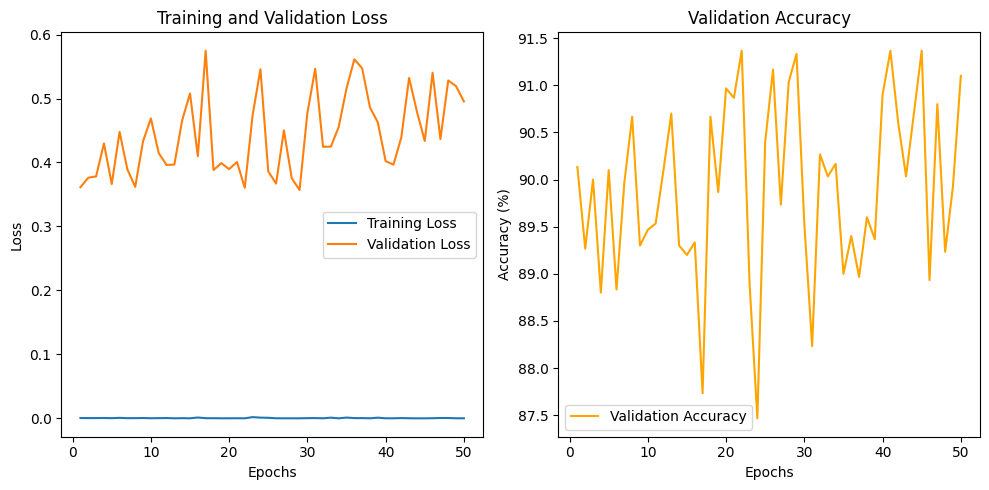

In [70]:
# Plotting the training progress
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Based on the graph above, it can be observed that:

1. The training losses consistently decrease over epochs, indicating that the model is effectively learning from the training data. Indicating that the model effectively leanrs from the training data and adjusts its parameter to minimize errors. 


2. The validation losses initially decrease but start to plateau or slightly increase after a certain point, suggesting potential overfitting or limited generalization to unseen data.  Initially, the validation losses decrease, suggesting that the model generalizes well to unseen data as training progresses. However after a certain point,  the validation losses either plateau or start to increase slightly. This could indicate that the model may be starting to overfit to the training data or struggling to generalize to unseen data.

## Classification Report

A classification report provides a concise summary of the key performance metrics for a classification model. 

In [71]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, bndboxes, labels in dataloader:
            images = images.to(device)
            labels = torch.tensor([labels_to_include.index(label) for label in labels]).to(device)
            
            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            # Append to lists for confusion matrix and classification report
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    return all_labels, all_predictions


In [72]:
# Evaluate the model
val_labels, val_predictions = evaluate_model(model, val_dataloader)

# Compute classification report
class_report = classification_report(val_labels, val_predictions, target_names=labels_to_include)
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

        Drag       0.85      0.87      0.86       626
       Loupe       0.86      0.92      0.88       591
       Point       0.90      0.90      0.90       610
       Scale       0.99      1.00      0.99       584
        None       0.97      0.87      0.92       589

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



In summary, based off the classification report, the model shows strong overall performance with an accuracy of 0.92. The F1-scores for all classes are quite high, indicating a good balance between precision and recall. 

## Confusion Matrix

Confusion matrix is a powerful tool for evaluating the performance of a classification model. It provides a detailed breakdown of how the model's predictions compare to the actual labels. Hence, I would like to see the detailed breakdown of it. 

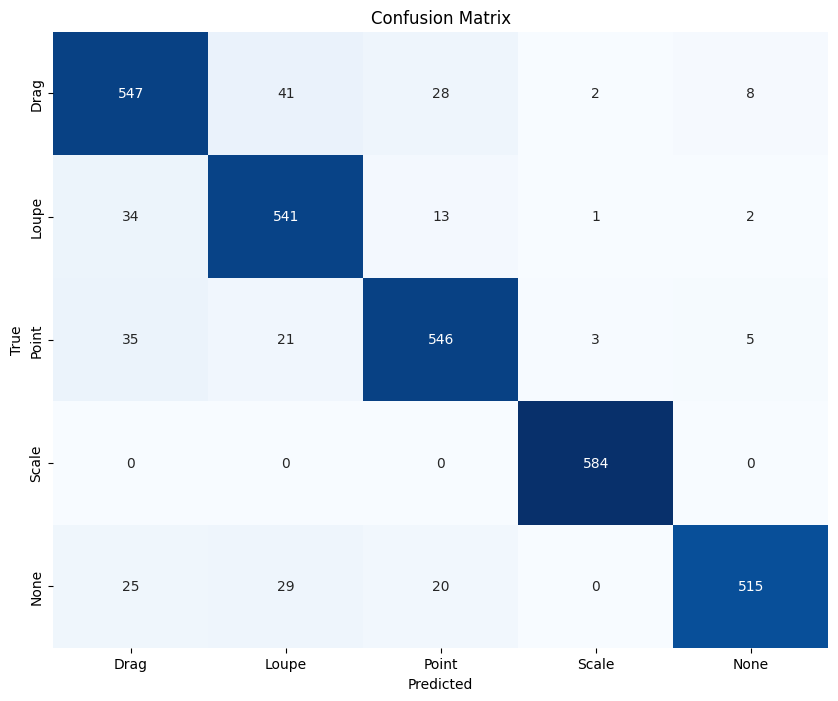

In [73]:
# Compute confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels_to_include, yticklabels=labels_to_include)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Based on the confusion matrix, the diagonal elements (the blues) are generally high, indicating that the model is correctly predicting these classes well. However, there are some moderate values off the diagonal, suggesting some misclassifications.

# Conclusion

- Good Accuracy and F1-scores: Based on the classification report and confusion matrix, the model shows a strong performance with accuracy of 92%. The F1-scores are quite high, which is a good indicator.

- Potential Overfitting: Based on the validation and training loss graph, the validation losses did not continue to decrease alongside training losses, it suggests potential overfitting. This means the model may be too complex relative to the amount of training data, or the data might not be diverse enough.

- High Final Validation Losses: The final validation losses are relatively high compared to the training losses, indicating that the model's performance on unseen data may not be as robust as desired.

## Potential Improvements

1. Introduce more diverse data augmentation techniques to expose the model to variations in input data during training, potentially improving generalization. 

2. Experiment with different CNN architectures or adjust the number of layers and neurons to find a better balance between complexity and performance.

3. Explore different hyperparameters (e.g., batch size, optimizer parameters) to find optimal settings for your specific dataset and model architecture. I tried to use GridSearchCV to find the best parameters, however the result were horrible. I need more time and explore deeper into this. 

4. Reducing the epochs might help to mitigate overfitting. If validation metrics stabilize or degrade after a certain point, it's a sign that the model may not benefit significantly from additional epochs.

In [74]:
# torch.save(model.state_dict(), 'test_model/hand_gesture_model_40val.pth')

# model_metadata = {
#     'model_state_dict': model.state_dict(),
#     'labels_to_include': labels_to_include,
#     'input_size': (3, 224, 224), 
#     'output_size': len(labels_to_include)
# }
# torch.save(model_metadata, 'test_model/hand_gesture_model_40val_metadata.pth')